In [6]:
from platform import python_version
import tensorflow as tf

print(tf.test.is_gpu_available())
print(python_version())

True
3.7.5


In [7]:
import os
import numpy as np
from os import listdir
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from keras import backend as K
import matplotlib.pyplot as plt

In [8]:
path="datasets/ofg_family/"
randomiser = np.random.RandomState(123)

In [9]:
def generate_image(family_dir):
    dic={}
    sub=[a for a in listdir(path+"/"+family_dir)]
    
    for ele in sub:
        mypath = path+"/"+family_dir+"/"+ele+"/"
        onlyfiles = [mypath+f for f in listdir(mypath)]
        
        addr = randomiser.choice(onlyfiles)
        original_img = np.array(Image.open(addr).resize((64,64),Image.ANTIALIAS))
        if ele[0].lower()=='f':
            dic['father'] = original_img
        elif ele[0].lower()=='m':
            dic['mother'] = original_img
        elif ele.lower()=='child_male':
            dic['child'] = original_img    
            dic['gender']=np.zeros((original_img.shape))
        elif ele.lower()=='child_female':
            dic['child'] = original_img    
            dic['gender'] = np.ones((original_img.shape))
    return [dic['father'],dic['mother'],dic['gender'],dic['child']]

def generate_batch(families_batch):
    np_images=[]
    
    for family in families_batch:
        res = generate_image(family)
        if( res != None):
            np_images.append(res)
    
    return np_images

In [10]:
for r, d, f in os.walk(path):
        all_families=d
        break

randomiser.shuffle(all_families)

train_families = all_families[:-500]
test_families = all_families[-500:]

In [11]:
OUTPUT_CHANNELS = 3

In [89]:
mean = 0.
std_dev = 0.02
lr = 0.0001
b1 = 0.9
b2 = 0.99
sd_random_normal_init = 0.02

EPOCHS = 10
batch = 250

In [90]:
def gen_downsample_parent(filters, size, apply_batchnorm=True, apply_dropout=False):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.ELU())
        
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(rate = 0.5))

    return result

In [91]:
def gen_upsample(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ELU())

    return result

In [92]:
def EncoderNN():
    down_stack_parent = [
    gen_downsample_parent(32,4,apply_batchnorm=True, apply_dropout=False),
    gen_downsample_parent(64,4,apply_batchnorm=True, apply_dropout=False)
    ]
    
#     down_stack_noise =[
# #   z = 4x4x64
#     gen_downsample_noise(64,4,apply_batchnorm=True), #8x8x64
#     gen_downsample_noise(32,4,apply_batchnorm=True) #16x16x32      
#     ]
    
    final_conv =[
        gen_upsample(32,4 ,apply_batchnorm = True)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

    concat = tf.keras.layers.Concatenate()

    father = tf.keras.layers.Input(shape=(64,64,3))
    mother = tf.keras.layers.Input(shape=(64,64,3))

    
    
    x1 = father
    for down in down_stack_parent:
        x1 = down(x1)
    
#     print(x1.shape)
    
    x2 = mother
    for down in down_stack_parent:
        x2 = down(x2) 
    
#     print(x2.shape)
    
#     n = noise
#     for down in down_stack_noise:
#         print(n.shape)
#         n = down(n)
#     print(n.shape)
#     print("NOISE STACK DONE")
    
    final = concat([x1,x2])
#     print(final.shape)
    final = final_conv[0](final)
    
    final = last(final)
#     print(final.shape)
    return tf.keras.Model(inputs=[father, mother], outputs=final)

In [93]:
encoder = EncoderNN()

In [94]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=b1)

In [95]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [96]:
def train_encoder(father_batch, mother_batch, target_batch, b_size):
    with tf.GradientTape() as enc_tape:
        gen_outputs = encoder([father_batch, mother_batch], training=True)
        
        diff = tf.abs(target_batch - gen_outputs)
        flatten_diff = tf.reshape(diff, (b_size, 64*64*3))
        
        encoder_loss_batch = tf.reduce_mean(flatten_diff, axis=1)
        encoder_loss = tf.reduce_mean(encoder_loss_batch)
    
    print("ENCODER_LOSS: ",tensor_to_array(encoder_loss))
    #calculate gradients
    encoder_gradients = enc_tape.gradient(encoder_loss,encoder.trainable_variables)

    #apply gradients on optimizer
    encoder_optimizer.apply_gradients(zip(encoder_gradients,encoder.trainable_variables))
    


In [97]:
def fit_encoder(train_ds, epochs, test_ds, batch):
    losses=np.array([])
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch+1))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
            batch_data = batch_data / 255 * 2 -1
            
            
            print("Generated batch", batch_data.shape)

            X_Father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_Mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            
            train_encoder(X_Father_train, X_Mother_train, Y_train,batch)
            
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
    print("______________________________TRAINING COMPLETED_______________________________")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.67210114
0.70680594


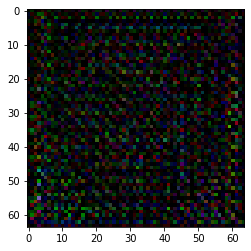

In [98]:
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
with tf.device('/gpu:0'):
    gen_output = encoder([father_inp, mother_inp], training=True)

temp = gen_output.numpy()
temp = np.squeeze(temp)
plt.imshow(temp)

print(np.amin(temp))
print(np.amax(temp))
# print(encoder.trainable_weights[0][0][0][0])
# plt.imshow((gen_output[0]+1)/2)

In [99]:
def disc_downsample_parent_target(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))

    return result

In [100]:
def disc_loss(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    
    return result

In [101]:
def Discriminator():

    father = tf.keras.layers.Input(shape=(64,64,3))
    mother = tf.keras.layers.Input(shape=(64,64,3))
    target = tf.keras.layers.Input(shape=(64,64,3))
    
    down_stack_parent_target = [
    disc_downsample_parent_target(32,4,apply_batchnorm=False), #32x32x32
    disc_downsample_parent_target(64,4,apply_batchnorm=True)   #16x16x64
    ]
    
    down_stack_combined =[
    disc_loss(192,4,apply_batchnorm=True),
    disc_loss(256,4,apply_batchnorm=False)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,padding='same',
                                  kernel_initializer=initializer) # linear layer
    
    
    concat = tf.keras.layers.Concatenate()
    x1 = father
    for down in down_stack_parent_target:
        x1 = down(x1)
    
    x2 = mother
    for down in down_stack_parent_target:
        x2 = down(x2)
        
    x3 = target
    for down in down_stack_parent_target:
        x3 = down(x3)
    
    combined = concat([x1,x2,x3])
    # combined is Batchx16x16x192
    
    x4 = combined
    for down in down_stack_combined:
        x4 = down(x4)
#     print(x4.shape)
    
    output = last(x4) #4X4 
#     print(output.shape)

    return tf.keras.Model(inputs=[father,mother,target], outputs=output)

In [102]:
discriminator = Discriminator()

In [103]:
# family_data = generate_image(all_families[126])
# p1 = tf.cast(family_data[0], tf.float32)
# p2 = tf.cast(family_data[1], tf.float32)
# c = tf.cast(family_data[2], tf.float32)

# discriminator = Discriminator()
# with tf.device('/cpu:0'):
#     disc_out = discriminator(inputs = [p1,p2,c], training=True)

In [104]:
LAMBDA = 100

In [105]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [115]:
def discriminator_loss(disc_real_output, disc_generated_output,b_size):
    # real_loss = loss_object(tf.ones_like(disc_real_output,dtype=tf.float32), disc_real_output) #L1 loss
    real_loss_diff = tf.abs(tf.ones_like(disc_real_output) - disc_real_output)
    real_flatten_diff = tf.reshape(real_loss_diff, (b_size, 4*4*1))
    real_loss_batch = tf.reduce_mean(real_flatten_diff, axis=1)
    real_loss = tf.reduce_mean(real_loss_batch)
    
    gen_loss_diff = tf.abs(tf.zeros_like(disc_generated_output) - disc_generated_output)
    gen_flatten_diff = tf.reshape(gen_loss_diff, (b_size, 4*4*1))
    gen_loss_batch = tf.reduce_mean(gen_flatten_diff, axis=1)
    gen_loss = tf.reduce_mean(gen_loss_batch)
    
    
    
#     generated_loss = tf.reduce_mean(tf.abs(tf.zeros_like(disc_generated_output) - disc_generated_output))
    # generated_loss = loss_object(tf.zeros_like(disc_generated_output,dtype=tf.float32), disc_generated_output) 
    total_disc_loss = real_loss + gen_loss
    print("D real loss: {}, D fake loss: {}".format(real_loss, gen_loss))
    return total_disc_loss

In [116]:
def generator_loss(disc_generated_output, gen_output, target,b_size):
    gen_loss_diff = tf.abs(tf.ones_like(disc_generated_output) - disc_generated_output)
    gen_flatten_diff = tf.reshape(gen_loss_diff, (b_size, 4*4*1))
    gen_loss_batch = tf.reduce_mean(gen_flatten_diff, axis=1)
    gen_loss = tf.reduce_mean(gen_loss_batch)
    
    l1_loss_diff = tf.abs(target - gen_output)
    l1_flatten_diff = tf.reshape(l1_loss_diff, (b_size, 64*64*3))
    l1_loss_batch = tf.reduce_mean(l1_flatten_diff, axis=1)
    l1_loss = tf.reduce_mean(l1_loss_batch)
 
    total_gen_loss = l1_loss + LAMBDA * gen_loss  
    print("Reconstruction loss: {}, GAN loss: {}".format(l1_loss, gen_loss))
    return total_gen_loss

In [117]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1 ,beta_2 = b2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1, beta_2 = b2)

In [118]:
def train_step(father_batch, mother_batch, target_batch,b_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_outputs = encoder([father_batch, mother_batch], training=True)
        print("Generated outputs",gen_outputs.shape)
        
        disc_real_output = discriminator([father_batch, mother_batch, target_batch], training=True)
        print("disc_real_output ", disc_real_output.shape)
        
        disc_generated_output = discriminator([father_batch, mother_batch, gen_outputs], training=True)
        print("disc_generated_output ", disc_generated_output.shape)
        
        gen_loss = generator_loss(disc_generated_output, gen_outputs, target_batch,b_size)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output,b_size)
    
        
    print("GEN_LOSS",tensor_to_array(gen_loss))
    print("DISC_LOSS",tensor_to_array(disc_loss))

    generator_gradients = gen_tape.gradient(gen_loss,encoder.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,encoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

In [119]:
def fit(train_ds, epochs, test_ds,batch):
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))

            print("Generated batch", batch_data.shape)

            X_father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
#             print("Xtrain",X_train.shape)
#             print("Batch converted to tensor")

            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            train_step(X_father_train, X_mother_train, Y_train, batch)
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
            
        family_data = generate_image(all_families[126])
        inp = [family_data[0],family_data[1]]
        inp = tf.cast(inp, tf.float32)
        father_inp = inp[0][tf.newaxis,...]
        mother_inp = inp[1][tf.newaxis,...]
        gen_output = encoder([father_inp, mother_inp], training=True)
        
        print(tf.reduce_min(gen_output))
        print(tf.reduce_max(gen_output))
        plt.figure()
        plt.imshow(gen_output[0,...])
        plt.show()
    print("______________________________TRAINING COMPLETED_______________________________")
    checkpoint.save(file_prefix = checkpoint_prefix)

In [120]:
concat = tf.keras.layers.Concatenate()

In [121]:
train_dataset = all_families[:-500]
test_dataset = all_families[-500:]
encoder = EncoderNN()
discriminator = Discriminator()

In [122]:
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=encoder,
                                 discriminator=discriminator)

______________________________EPOCH 0_______________________________
Generated batch (250, 4, 64, 64, 3)
Generated outputs (250, 64, 64, 3)
disc_real_output  (250, 4, 4, 1)
disc_generated_output  (250, 4, 4, 1)
Reconstruction loss: 128.31607055664062, GAN loss: 1.177240252494812
D real loss: 1.201253890991211, D fake loss: 0.3406824469566345
GEN_LOSS 246.0401
DISC_LOSS 1.5419364
Trained for batch 1/6
Generated batch (250, 4, 64, 64, 3)
Generated outputs (250, 64, 64, 3)
disc_real_output  (250, 4, 4, 1)
disc_generated_output  (250, 4, 4, 1)
Reconstruction loss: 124.35713195800781, GAN loss: 0.5538030862808228
D real loss: 0.5480087399482727, D fake loss: 0.5566259622573853
GEN_LOSS 179.73744
DISC_LOSS 1.1046348
Trained for batch 2/6
Generated batch (250, 4, 64, 64, 3)
Generated outputs (250, 64, 64, 3)
disc_real_output  (250, 4, 4, 1)
disc_generated_output  (250, 4, 4, 1)
Reconstruction loss: 124.46698760986328, GAN loss: 0.3875274360179901
D real loss: 0.36949053406715393, D fake loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 6/6
tf.Tensor(-0.63486814, shape=(), dtype=float32)
tf.Tensor(0.6541769, shape=(), dtype=float32)


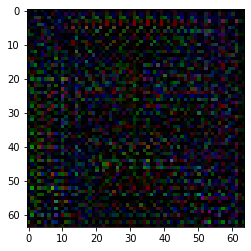

______________________________EPOCH 1_______________________________
Generated batch (250, 4, 64, 64, 3)
Generated outputs (250, 64, 64, 3)
disc_real_output  (250, 4, 4, 1)
disc_generated_output  (250, 4, 4, 1)
Reconstruction loss: 128.55490112304688, GAN loss: 0.8373132944107056
D real loss: 0.5141323804855347, D fake loss: 0.3430391252040863
GEN_LOSS 212.28622
DISC_LOSS 0.85717154
Trained for batch 1/6
Generated batch (250, 4, 64, 64, 3)
Generated outputs (250, 64, 64, 3)
disc_real_output  (250, 4, 4, 1)
disc_generated_output  (250, 4, 4, 1)
Reconstruction loss: 123.75494384765625, GAN loss: 0.9064200520515442
D real loss: 0.5166274309158325, D fake loss: 0.3070701062679291
GEN_LOSS 214.39694
DISC_LOSS 0.82369757
Trained for batch 2/6
Generated batch (250, 4, 64, 64, 3)
Generated outputs (250, 64, 64, 3)
disc_real_output  (250, 4, 4, 1)
disc_generated_output  (250, 4, 4, 1)
Reconstruction loss: 124.06312561035156, GAN loss: 0.8814403414726257
D real loss: 0.43993377685546875, D fake 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trained for batch 6/6
tf.Tensor(-0.6575018, shape=(), dtype=float32)
tf.Tensor(0.6488706, shape=(), dtype=float32)


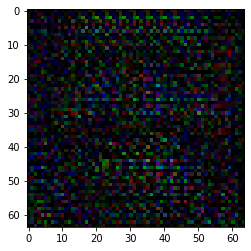

______________________________EPOCH 2_______________________________
Generated batch (250, 4, 64, 64, 3)
Generated outputs (250, 64, 64, 3)
disc_real_output  (250, 4, 4, 1)
disc_generated_output  (250, 4, 4, 1)
Reconstruction loss: 126.34243774414062, GAN loss: 0.7812826037406921
D real loss: 0.2727437913417816, D fake loss: 0.2777853012084961
GEN_LOSS 204.4707
DISC_LOSS 0.5505291
Trained for batch 1/6
Generated batch (250, 4, 64, 64, 3)
Generated outputs (250, 64, 64, 3)
disc_real_output  (250, 4, 4, 1)
disc_generated_output  (250, 4, 4, 1)
Reconstruction loss: 126.7296371459961, GAN loss: 0.9055788516998291
D real loss: 0.27363109588623047, D fake loss: 0.2171110361814499
GEN_LOSS 217.28752
DISC_LOSS 0.49074215
Trained for batch 2/6
Generated batch (250, 4, 64, 64, 3)
Generated outputs (250, 64, 64, 3)
disc_real_output  (250, 4, 4, 1)
disc_generated_output  (250, 4, 4, 1)
Reconstruction loss: 125.53282928466797, GAN loss: 1.0124112367630005
D real loss: 0.28076499700546265, D fake lo

In [ ]:
with tf.device('/cpu:0'):
    fit(train_dataset, EPOCHS, test_dataset,batch)

In [48]:
family_data = generate_image(all_families[1])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=True)
print(tf.reduce_min(gen_output))
print(tf.reduce_max(gen_output))
plt.imshow(gen_output[0,...])

AssertionError: Could not compute output Tensor("conv2d_transpose_7/Identity:0", shape=(None, 64, 64, 3), dtype=float32)